# Orientation to PACE/OCI Terrestrial Products

**Tutorial Lead:** Skye Caplan (NASA, SSAI)

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA ocean color data.

</div>

[edl]: https://urs.earthdata.nasa.gov

## Summary

This notebook introduces the Level-2 files containing the surface reflectance product from the Ocean Color Instrument (OCI) on board the [PACE satellite]. The visualizations rely on flags accompanying the data variables that enable masking for features more relevant to terrestrial data products. The notebook highlights the hyperspectral-enabled vegetation indices (VIs) made possible by the high spectral resolution of OCI.

[PACE satellite]: https://pace.oceansciences.org

## Learning objectives

By the end of this tutorial you will be able to:

- Open OCI surface reflectance products
- Mask features you can ignore using built-in flags
- Compare VIs developed using different spectral features

## Contents

1. [Setup](#1.-Setup)
2. [Search and Open Surface Reflectance Data](#2.-Search-and-Open-Surface-Reflectance-Data)
3. [Mask Data for Clouds and Water](#3.-Mask-for-Clouds-and-Water)
4. [Working with PACE Terrestrial Data](#4.-Working-with-PACE-Terrestrial-Data)

## 1. Setup

We begin by importing the packages used in this notebook. At first glance, the `cf_xarray` package appears unused and should therefore not be imported. Since it actually provides the `cf` attribute used below on certain `xarray` data structures, we indicate that the import is necessary by the inline comment `# noqa: F401` referencing rule [F401](https://docs.astral.sh/ruff/rules/unused-import/). Likewise for `hvplot.xarray` and the `hvplot` attribute.

In [1]:
import cartopy
import cf_xarray  # noqa: F401
import earthaccess
import hvplot.xarray  # noqa: F401
import matplotlib.pyplot as plt
import xarray as xr

crs = cartopy.crs.PlateCarree()

[back to top](#Contents)

## 2. Search and Open Surface Reflectance Data

Set and persist your Earthdata login credentials.

In [2]:
auth = earthaccess.login(persist=True)

We will use `earthaccess` to open a Level-2 surface reflectance granule that covers part of the Great Lakes region of North America. When fetching one specific granule, use the `concept_id` argument to provide a unique identifier looked up elsewhere.

In [3]:
results = earthaccess.search_data(
    concept_id="G3406522735-OB_CLOUD",
)
for item in results:
    display(item)

Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L2_SFREFL'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 48.76606, 'Longitude': -65.20255}, {'Latitude': 42.73293, 'Longitude': -99.1249}, {'Latitude': 25.62384, 'Longitude': -90.6707}, {'Latitude': 30.94837, 'Longitude': -63.88272}, {'Latitude': 48.76606, 'Longitude': -65.20255}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-07-01T17:51:12Z', 'EndingDateTime': '2024-07-01T17:56:12Z'}}
Size(MB): 750.2740449905396
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240701T175112.L2.SFREFL.V3_0.nc']

In [4]:
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# this cell is tagged to be removed from HTML renders,
# but we currently want to download when we don't have direct access
if not earthaccess.__store__.in_region:
    paths = earthaccess.download(results, "granules")

We use `xr.open_datatree()` to access all "groups" of variables (a.k.a. "datasets") within a NetCDF file. It will be easier to work with a single dataset, which we create by merging the data and coordinate variables we need from different groups. Longitude and latitude appear as data variables, however, so they must be explicitly set as coordinates.

In [6]:
datatree = xr.open_datatree(paths[0])
dataset = xr.merge(
    (
        datatree.ds,
        datatree["geophysical_data"].ds[["rhos", "l2_flags"]],
        datatree["sensor_band_parameters"].coords,
        datatree["navigation_data"].ds.set_coords(("longitude", "latitude")).coords,
    )
)
dataset

/tmp/ipykernel_792/1443598022.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  datatree = xr.open_datatree(paths[0])


<xarray.Dataset> Size: 1GB
Dimensions:        (number_of_lines: 1710, pixels_per_line: 1272,
                    wavelength_3d: 122)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    longitude      (number_of_lines, pixels_per_line) float32 9MB ...
    latitude       (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    rhos           (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
Attributes: (12/45)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20240701T175112.L2.SFREFL.V3_...
    processing_version:                3.0
    history:                           l2gen par=/data6/sdpsoper/vdc/vpu25/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_max:                -63.882717
    geospatial_lon_min:                -99.1249
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9674437642097473

In the above display of our Level-2 file, we have the data variables `rhos` and `l2_flags`. The `rhos` variable are surface reflectances, and the `l2_flags` are quality flags as defined by the Ocean Biology Processing Group (OBPG).

We can also see which wavelengths we have surface reflectance measurements at by accessing the `wavelength_3d` coordinate:

In [7]:
dataset["wavelength_3d"]

<xarray.DataArray 'wavelength_3d' (wavelength_3d: 122)> Size: 976B
array([ 346.,  351.,  356.,  361.,  366.,  371.,  375.,  380.,  385.,  390.,
        395.,  400.,  405.,  410.,  415.,  420.,  425.,  430.,  435.,  440.,
        445.,  450.,  455.,  460.,  465.,  470.,  475.,  480.,  485.,  490.,
        495.,  500.,  505.,  510.,  515.,  520.,  525.,  530.,  535.,  540.,
        545.,  550.,  555.,  560.,  565.,  570.,  575.,  580.,  586.,  615.,
        620.,  625.,  630.,  635.,  640.,  642.,  645.,  647.,  650.,  652.,
        655.,  657.,  660.,  662.,  665.,  667.,  670.,  672.,  675.,  677.,
        679.,  682.,  697.,  699.,  702.,  704.,  707.,  709.,  712.,  714.,
        719.,  724.,  729.,  734.,  739.,  742.,  744.,  747.,  749.,  752.,
        754.,  772.,  774.,  779.,  784.,  789.,  794.,  799.,  804.,  809.,
        814.,  819.,  824.,  829.,  835.,  840.,  845.,  850.,  855.,  860.,
        865.,  870.,  875.,  880.,  885.,  890.,  895., 1038., 1249., 1618.,
       2131., 2258.])
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
Attributes:
    long_name:  wavelengths
    units:      nm
    valid_min:  0
    valid_max:  20000

Note that "wavelength_3d" is an indexed coordinate, which allows us to subset the dataset by slicing or choosing individual wavelengths. The `method="nearest"` argument lets us select one wavelength without knowning its exact value.

In [8]:
rhos_860 = dataset["rhos"].sel({"wavelength_3d": 860}, method="nearest")

Now we can plot surface reflectance at this one wavelength in the near-infrared (NIR), where land is bright and we can differentiate land, water, and clouds.

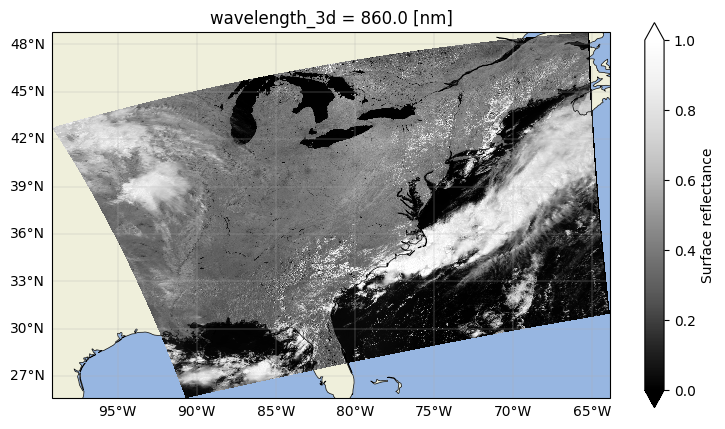

In [9]:
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw={"projection": crs})
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25)
ax.coastlines(linewidth=0.5)
ax.add_feature(cartopy.feature.OCEAN, edgecolor="w", linewidth=0.01)
ax.add_feature(cartopy.feature.LAND, edgecolor="w", linewidth=0.01)
rhos_860.plot(x="longitude", y="latitude", cmap="Greys_r", vmin=0, vmax=1.0)
plt.show()

Great! We've plotted the surface reflectance at a single band for the whole scene. However, there are some features in this image that we want to exclude from our analysis.

[back to top](#Contents)

## 3. Mask for Clouds and Water

Level-2 files usually include information on the quality of each pixel in the scene, presented in the `l2_flags` variable. Let's look at it a little more closely.

In [10]:
dataset["l2_flags"]

<xarray.DataArray 'l2_flags' (number_of_lines: 1710, pixels_per_line: 1272)> Size: 9MB
[2175120 values with dtype=int32]
Coordinates:
    longitude  (number_of_lines, pixels_per_line) float32 9MB ...
    latitude   (number_of_lines, pixels_per_line) float32 9MB ...
Dimensions without coordinates: number_of_lines, pixels_per_line
Attributes:
    long_name:      Level-2 Processing Flags
    valid_min:      -2147483648
    valid_max:      2147483647
    flag_masks:     [          1           2           4           8         ...
    flag_meanings:  ATMFAIL LAND PRODWARN HIGLINT HILT HISATZEN COASTZ SPARE ...

At first glance, we can see that `l2_flags` is in the same shape as the surface reflectance we plotted above. The attributes look sorta meaningful, but also sorta like random numbers and abbreviations. If we were to plot `l2_flags`, the result wouldn't look like anything useful at all. This is because the values in `l2_flags` include many quality flags compactly encoded in the binary representation of an integer. In order to use the flags applied to each pixel, we need a decoded representation. Since all OB.DAAC data follows the [CF Metadata Conventions](http://cfconventions.org/), we only need to import the `cf_xarray` package to access the decoded flags.

For example, say we want to mask any pixels flagged as clouds and or water in our data. First, we have to make sure that the `l2_flags` variable is readable by `cf_xarray` so that we can eventually apply them to the data. We can check this using the built in `is_flag_variable` property.

In [11]:
dataset["l2_flags"].cf.is_flag_variable

True

The statement returned `True`, which means `l2_flags` is recognized as a flag variable. By referencing the OBPG [ocean color flags documentation](https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/), we find the name of the flags we want to mask out. In this case, "CLDICE" is the cloud flag, and while there is no specific water mask (this is an ocean mission, after all) there is a "LAND" flag we can invert to mask out water. The expressions in the cell below will retain any pixel identified as land which is also not a cloud (thanks to the `~`).

[ocean color flags documentation]: https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/

In [12]:
cldwater_mask = (
    (dataset["l2_flags"].cf == "LAND")
    & ~(dataset["l2_flags"].cf == "CLDICE")
)
rhos = dataset["rhos"].where(cldwater_mask)

Note that we need to redefine the `rhos_860` selection with the new masked dataset.

In [13]:
rhos_860 = rhos.sel({"wavelength_3d": 860}, method="nearest")

Then, we can see if the mask worked by plotting the data once again.

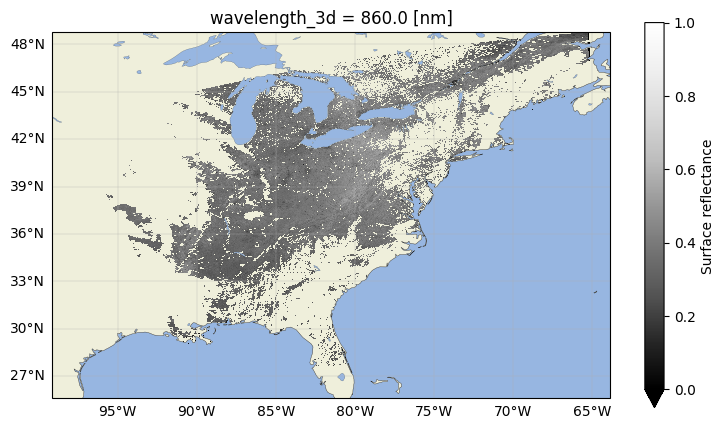

In [14]:
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw={"projection": crs})
ax.coastlines(linewidth=0.25)
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25)
ax.add_feature(cartopy.feature.OCEAN, edgecolor="w", linewidth=0.01)
ax.add_feature(cartopy.feature.LAND, edgecolor="w", linewidth=0.01)
ax.add_feature(cartopy.feature.LAKES, edgecolor="k", linewidth=0.1)
rhos_860.plot(x="longitude", y="latitude", cmap="Greys_r", vmin=0, vmax=1.0)
plt.show()

[back to top](#Contents)

## 4. Working with PACE Terrestrial Data

Now that we have our surface reflectance data masked, we can start doing some analysis. A relatively simple but informative use of surface reflectance data is the calculation of vegetation indices (VIs). VIs use the well-known, idealized spectral shape of leaves and other materials to determine surface features contributing to a pixel. Vegetation health, relative water content, or even the presence of snow can be measured using VIs. They've been used in terrestrial remote sensing for decades, and are particularly valuable when considering the limited number of bands in previous multispectral sensors. They can, of course, also be calculated with hyperspectral sensors like PACE.

### Multispectral Vegetation Indices

Let's take NDVI for example. NDVI is a metric which quantifies plant "greenness", which is related to the abundance and health of the vegetation in a pixel. It is a normalized ratio of the surface reflectance for red ($\rho_{red}$) and near-infrared ($\rho_{NIR}$) bands:

$$
  NDVI = \frac{\rho_{NIR} - \rho_{red}}{\rho_{NIR} + \rho_{red}}
$$

You'll notice that the equation does not mention specific wavelengths, but rather just requires a "red" measurement and a "NIR" measurement. With PACE, we have a lot of measurements throughout the red and NIR regions of the spectrum. To visualize the spectra, we want to plot across the wavelength dimension of individual pixels, so we'll take just a small sample from the dataset. We also like to separate the hyperspectral (ultraviolet to NIR wavelengths) and multispectral (NIR to SWIR wavelengths) regions when plotting spectra.

In [15]:
sample_rhos = rhos.sel(
    {"number_of_lines": 900, "pixels_per_line": slice(None, None, 25)}
)
hyper_rhos = sample_rhos.sel({"wavelength_3d": slice(None, 895)})
multi_rhos = sample_rhos.sel({"wavelength_3d": slice(1038, None)})

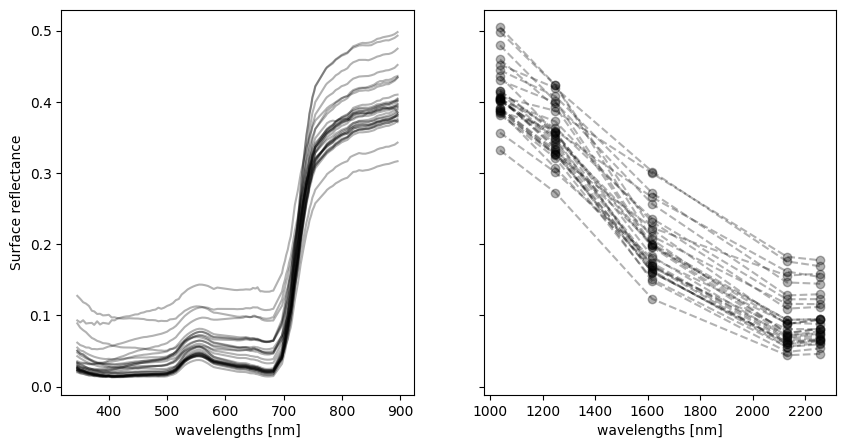

In [16]:
fig, (a, b) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
hyper_rhos.plot.line("k", x="wavelength_3d", ax=a, alpha=0.3, add_legend=False)
multi_rhos.plot.line("k--o", x="wavelength_3d", ax=b, alpha=0.3, add_legend=False)
b.set_ylabel("")
plt.show()

To calculate NDVI and other heritage multispectral indices with PACE, you could choose a single band from each region. However, doing so would mean capturing only the information from one of OCI's narrow 5 nm bands. In other words, we would miss out on information from surrounding wavelengths that improve these calculations and would have otherwise been included from other sensors. To preserve continuity with those sensors and calculate a more comparable NDVI, we can take an average of several OCI bands to simulate a multispectral measurement, incorporating as much relevant information into the calculation as possible.

We'll take MODIS's red and NIR bandwidths and average the PACE measurements together.

In [17]:
rhos_red = rhos.sel({"wavelength_3d": slice(620, 670)}).mean("wavelength_3d")
rhos_nir = rhos.sel({"wavelength_3d": slice(840, 875)}).mean("wavelength_3d")

Now, we can use those averaged reflectances to calculate NDVI.

In [18]:
ndvi = (rhos_nir - rhos_red) / (rhos_nir + rhos_red)
ndvi.attrs["long_name"] = "Normalized Difference Vegetation Index (NDVI)"

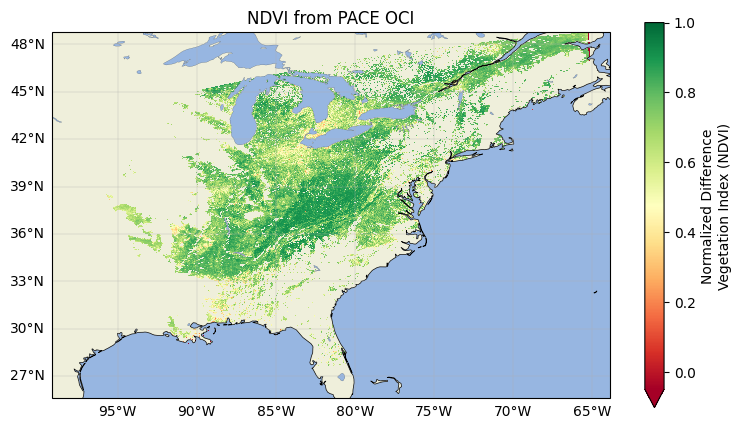

In [19]:
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw={"projection": crs})
ax.coastlines(linewidth=0.5)
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25)
ax.add_feature(cartopy.feature.OCEAN, edgecolor="w", linewidth=0.01)
ax.add_feature(cartopy.feature.LAND, edgecolor="w", linewidth=0.01)
ax.add_feature(cartopy.feature.LAKES, edgecolor="k", linewidth=0.1)
ndvi.plot(x="longitude", y="latitude", cmap="RdYlGn", vmin=-0.05, vmax=1.0)
ax.set_title("NDVI from PACE OCI")
plt.show()

Making these heritage calculations are important for many reasons, not least of which is because the MODIS instruments are reaching the end of their lives and will soon be decommissioned. PACE can continue the time series of these VI datasets that would otherwise be lost. However, as a hyperspectral instrument, PACE/OCI is able to go beyond these legacy calculations and create new products, as well!

### Hyperspectral-enabled Vegetation Indices

Hyperspectral-enabled VIs are still band ratios, but rather than using wide bands to capture the general aspects of a spectrum, they target minute fluctuations in surface reflectances to describe detailed features of a pixel, such as relative pigment concentration in plants. This means that, unlike multispectral VIs, these indices require the narrow bandwidths inherent to OCI data. In other words, we don't want to do any band averaging as we did above, because we'd likely dilute the very signal we want to pull out. The calculations for this type of VI are actually much simpler!

We'll take the Chlorophyll Index Red Edge (CIRE) as an example of a hyperspectral-enabled VI. CIRE uses bands from the red edge and the NIR to get at relative canopy chlorophyll content:

$$
CIRE = \frac{\rho_{800}}{\rho_{705}} - 1
$$

Because we're not doing any averaging, all we have to do is grab the bands from our dataset and follow the equation. We'll use the closest bands that the SFREFL suite has to 800 and 705 nm.

In [20]:
rhos_800 = rhos.sel({"wavelength_3d": 800}, method="nearest")
rhos_705 = rhos.sel({"wavelength_3d": 705}, method="nearest")

cire = (rhos_800 / rhos_705) - 1
cire.attrs["long_name"] = "Chlorophyll Index Red Edge (CIRE)"

We can compare these maps side by side to see similarities and differences in the patterns of each VI.

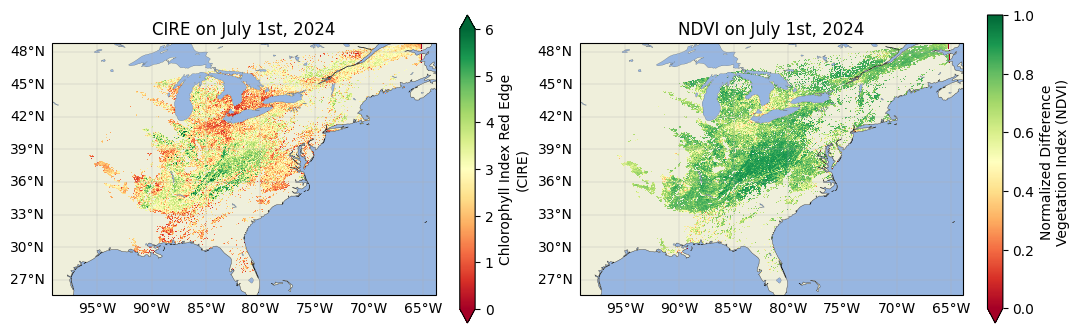

In [21]:
fig, (a, b) = plt.subplots(1, 2, figsize=(13, 4), subplot_kw={"projection": crs})
plot_args = {
    "x": "longitude",
    "y": "latitude",
    "cmap": "RdYlGn",
    "vmin": 0,
}
for ax in (a, b):
    ax.coastlines(linewidth=0.25)
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25)
    ax.add_feature(cartopy.feature.OCEAN, edgecolor="w", linewidth=0.01)
    ax.add_feature(cartopy.feature.LAND, edgecolor="w", linewidth=0.01)
    ax.add_feature(cartopy.feature.LAKES, edgecolor="k", linewidth=0.1)
cire.plot(ax=a, **plot_args, vmax=6)
a.set_title("CIRE on July 1st, 2024")
ndvi.plot(ax=b, **plot_args, vmax=1)
b.set_title("NDVI on July 1st, 2024")
plt.subplots_adjust(wspace=0.1)
plt.show()

Comparing these two plots, we can see some similarities and differences. Generally, the patterns of high and low values fall in the same places - this is because NDVI is essentially measuring the amount of green vegetation, and CIRE is measuring the amount of green pigment in plants. However, CIRE also has a higher dynamic range than NDVI does. For one, NDVI saturates as vegetation density increases, so a wide range of ecosystems with varying amounts of green vegetation may have very similar NDVI values. On the other hand, CIRE is not as affected by the leaf area, and can instead hone in on the relative amount of chlorophyll pigment in a pixel rather than the amount of leaves. This is a major advantage of CIRE and other hyperspectral-enabled VIs like the Carotenoid Content Index (Car), enabling us to track specific biochemical shifts in plants that correspond to states of photosynthetic or photoprotective ability, and thus provide insight on plant physiological condition.

If calculating these indices manually felt a little tedious, not to worry! PACE/OCI provides 10 VIs in its LANDVI products available in Level-2 (`short_name="PACE_OCI_L2_LANDVI"`) and Level-3 (`short_name="PACE_OCI_L3M_LANDVI"`). The suite includes 6 heritage indices and 4 narrowband pigment indices including CIRE. Read more about it in the ATBD (in review).

In [22]:
results = earthaccess.search_data(concept_id="G3407628214-OB_CLOUD")
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# this cell is tagged to be removed from HTML renders,
# but we currently want to download when we don't have direct access
if not earthaccess.__store__.in_region:
    paths = earthaccess.download(results, "granules")

The Level-3 data products come binned and gridded on a global projection at multiple temporal and spatial resolutions. The granule shown here is a monthly, 0.1 degree aggregate. We'll conclude by dropping in a nifty interactive visualization brought to you by the `hvplot` package.

In [24]:
dataset = xr.open_dataset(paths[0])
array = dataset.drop_vars("palette").to_array("Product")
array.attrs["long_name"] = "Vegetation Index"
array.hvplot(
    x="lon",
    y="lat",
    cmap="magma",
    aspect=2,
    title="July 2024 Monthly Average",
    rasterize=True,
    widget_location='top',
)

Column
    [0] WidgetBox(align=('center', 'start'))
        [0] Select(name='Product', options=[np.str_('ndvi'), ...], value=np.str_('ndvi'))
    [1] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='top')

[back to top](#Contents)

<div class="alert alert-info" role="alert">

You have completed the notebook introducing terrestrial data products from OCI. We suggest looking at the notebook on "Satellite Data Visualization" for tips on making beautiful PACE/OCI images.

</div>